## Introduction

## Methods and Results

In [2]:
library(broom)
library(repr)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(dplyr)
library(glmnet)
library(cowplot)
library(modelr)
library(tidyverse)
library(rsample)
library(caret)
library(yardstick)

salaries <- read_csv("data/ds_salaries.csv")


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: ‘modelr’


The following objects are masked from ‘package:mltools’:

    mse, rmse


The following object is masked from ‘package:broom’:

    bootstrap


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ modelr::bootstrap() masks broom::bootstrap()
✖ dplyr::combine()    masks gridExtra::combine()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats:

### EDA

### Methods


In [3]:
# remove unnecessary variables
preprocessed_salaries <- salaries |>
  select(-c("...1", salary_currency, work_year, salary, employee_residence))

In [4]:
# feature engineering on company_location, job_title
no_am <- c("CA", "US", "MX", "HN")
so_am <- c("CL", "CO", "BR")
eur <- c("SI", "PL", "NL", "MT", "MO", "LU", "MD", "IT", "UA", 
         "IE", "HU", "HR", "GR", "GB", "FR", "ES", "EE", "DK", "DE", "AT", "BE", "CH", "CZ", "RO", "PT")
asia <- c("MY", "VN", "SG", "RU", "JP", "CN", "IN", "PK", "IL", "IQ", "IR", "TR", "AE")
afr <- c("KE", "DZ", "NG")
oce <- c("NZ", "AU", "AS")

In [5]:
# cont is the company location in terms of continent
preprocessed_salaries <- preprocessed_salaries %>%
    mutate(cont = "")

preprocessed_salaries[1, ]

experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size,cont
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MI,FT,Data Scientist,79833,0,DE,L,


In [6]:
for(i in 1:607){
    if(preprocessed_salaries[i, ]$company_location %in% no_am){
        preprocessed_salaries[i, ]$cont = "no_am"
    } else if(preprocessed_salaries[i, ]$company_location %in% so_am) {
        preprocessed_salaries[i, ]$cont = "so_am"
    } else if(preprocessed_salaries[i, ]$company_location %in% eur){
        preprocessed_salaries[i, ]$cont = "eur"
    } else if(preprocessed_salaries[i, ]$company_location %in% asia){
        preprocessed_salaries[i, ]$cont = "asia"
    } else if(preprocessed_salaries[i, ]$company_location %in% afr){
        preprocessed_salaries[i, ]$cont = "afr"
    } else if(preprocessed_salaries[i, ]$company_location %in% oce) {
        preprocessed_salaries[i, ]$cont = "oce"
    }
}

head(select(preprocessed_salaries, company_location, cont), 10)

company_location,cont
<chr>,<chr>
DE,eur
JP,asia
GB,eur
HN,no_am
US,no_am
US,no_am
US,no_am
HU,eur
US,no_am


In [7]:
counts <- preprocessed_salaries %>%
    group_by(job_title) %>%
    summarize(counts = n())

counts

job_title,counts
<chr>,<int>
3D Computer Vision Researcher,1
AI Scientist,7
Analytics Engineer,4
Applied Data Scientist,5
Applied Machine Learning Scientist,4
BI Data Analyst,6
Big Data Architect,1
Big Data Engineer,8
Business Data Analyst,5


In [8]:
# field will contain the job_title groupings
preprocessed_salaries <- preprocessed_salaries %>%
    mutate(field = "")

preprocessed_salaries[1, ]

experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size,cont,field
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
MI,FT,Data Scientist,79833,0,DE,L,eur,


In [9]:
for(i in 1:607){
    if(str_detect(preprocessed_salaries$job_title[i], "Data Scien")) {
        preprocessed_salaries$field[i] = "Data Science"
    } else if(str_detect(preprocessed_salaries$job_title[i], "Data Analy")) {
        preprocessed_salaries$field[i] = "Data Analysis"       
    } else if(str_detect(preprocessed_salaries$job_title[i], "Machine Learning") || str_detect(preprocessed_salaries$job_title[i], "ML")){
        preprocessed_salaries$field[i] = "Machine Learning"
    } else if(str_detect(preprocessed_salaries$job_title[i], "Data Engineer")) {
        preprocessed_salaries$field[i] = "Data Engineering"
    } else {
        preprocessed_salaries$field[i] = "Other"
    }
}

head(select(preprocessed_salaries, job_title, field), 20)

job_title,field
<chr>,<chr>
Data Scientist,Data Science
Machine Learning Scientist,Machine Learning
Big Data Engineer,Data Engineering
Product Data Analyst,Data Analysis
Machine Learning Engineer,Machine Learning
Data Analyst,Data Analysis
Lead Data Scientist,Data Science
Data Scientist,Data Science
Business Data Analyst,Data Analysis


In [10]:
# Remove job_title and company_location
feat_salaries <- preprocessed_salaries %>%
    select(-job_title, -company_location)

# Convert all string parameters to factors
feat_salaries$company_size <- as.factor(feat_salaries$company_size)
feat_salaries$cont <- as.factor(feat_salaries$cont)
feat_salaries$field <- as.factor(feat_salaries$field)
feat_salaries$experience_level <- as.factor(feat_salaries$experience_level)
feat_salaries$employment_type <- as.factor(feat_salaries$employment_type)

head(feat_salaries)

experience_level,employment_type,salary_in_usd,remote_ratio,company_size,cont,field
<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
MI,FT,79833,0,L,eur,Data Science
SE,FT,260000,0,S,asia,Machine Learning
SE,FT,109024,50,M,eur,Data Engineering
MI,FT,20000,0,S,no_am,Data Analysis
SE,FT,150000,50,L,no_am,Machine Learning
EN,FT,72000,100,L,no_am,Data Analysis


## Forward Selection

In [11]:
table(feat_salaries$field)


   Data Analysis Data Engineering     Data Science Machine Learning 
             131              158              192               68 
           Other 
              58 

In [12]:
# data splitting
set.seed(301)

# Perform the initial split (75% training, 25% testing by default,
# which is a suitable and common ratio for data splitting)
data_split <- initial_split(feat_salaries, prop = 0.75)

# Extract training and testing sets
train_data <- training(data_split)
test_data <- testing(data_split)

dim(train_data)
dim(test_data)

[1] 455   7

[1] 152   7

In [13]:
train_data[1, ]

experience_level,employment_type,salary_in_usd,remote_ratio,company_size,cont,field
<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
SE,FT,140000,100,L,no_am,Data Analysis


In [14]:
# Determining total number of predictors, including dummy variables
model_matrix <- model.matrix(salary_in_usd ~ ., data = train_data)
# Display the dimensions of the model matrix
dim(model_matrix)

[1] 455  19

In [15]:
# Check the levels for each factor variable in the dataset
factor_levels <- sapply(train_data, function(x) if(is.factor(x)) levels(x) else NA)
factor_levels
# Checking the number of levels for each categorical variables
factor_levels_count <- sapply(train_data, function(x) if(is.factor(x)) length(levels(x)) else NA)
print(factor_levels_count)

$experience_level
[1] "EN" "EX" "MI" "SE"

$employment_type
[1] "CT" "FL" "FT" "PT"

$salary_in_usd
[1] NA

$remote_ratio
[1] NA

$company_size
[1] "L" "M" "S"

$cont
[1] "afr"   "asia"  "eur"   "no_am" "oce"   "so_am"

$field
[1] "Data Analysis"    "Data Engineering" "Data Science"     "Machine Learning"
[5] "Other"

experience_level  employment_type    salary_in_usd     remote_ratio 
               4                4               NA               NA 
    company_size             cont            field 
               3                6                5 


In [16]:
# Check how many coefficients (betas) you will have
num_coefficients <- ncol(model_matrix) - 1 # Subtract 1 to exclude the intercept
num_coefficients

[1] 18

Number of coefficients explained: each numeric variable gets one column/coefficient, each categorical variable gets (# of levels -1) dummy variables as coefficients (because reference level is not included), and yeah we get rid of the intercept column whuich is all 1. we have from the order of factor_levels: 3+3+1+1+2+5+4-1 = 18 coefficients in total.

In [17]:
# forward selection
forward_sel <- regsubsets(salary_in_usd ~ ., nvmax = 18,
                          data = train_data,
                          method = "forward")
forward_summary <- summary(forward_sel)
forward_summary

Subset selection object
Call: regsubsets.formula(salary_in_usd ~ ., nvmax = 18, data = train_data, 
    method = "forward")
18 Variables  (and intercept)
                      Forced in Forced out
experience_levelEX        FALSE      FALSE
experience_levelMI        FALSE      FALSE
experience_levelSE        FALSE      FALSE
employment_typeFL         FALSE      FALSE
employment_typeFT         FALSE      FALSE
employment_typePT         FALSE      FALSE
remote_ratio              FALSE      FALSE
company_sizeM             FALSE      FALSE
company_sizeS             FALSE      FALSE
contasia                  FALSE      FALSE
conteur                   FALSE      FALSE
contno_am                 FALSE      FALSE
contoce                   FALSE      FALSE
contso_am                 FALSE      FALSE
fieldData Engineering     FALSE      FALSE
fieldData Science         FALSE      FALSE
fieldMachine Learning     FALSE      FALSE
fieldOther                FALSE      FALSE
1 subsets of each size up to 

In [18]:
forward_summary_df <- tibble(
    n_input_variables = 1:18,
    RSQ = forward_summary$rsq,
    RSS = forward_summary$rss,
    ADJ_R2 = forward_summary$adjr2,
    Cp = forward_summary$cp,
    BIC = forward_summary$bic,
)
forward_summary_df

n_input_variables,RSQ,RSS,ADJ_R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2770677,1.769440e+12,0.2754718,137.08252,-135.3794
2,0.3379894,1.620328e+12,0.3350601,89.52462,-169.3146
3,0.3813322,1.514243e+12,0.3772169,56.26663,-194.0038
4,0.3898055,1.493504e+12,0.3843816,51.37383,-194.1583
5,0.3990691,1.470831e+12,0.3923772,45.83821,-194.9985
6,0.4060437,1.453760e+12,0.3980889,42.16460,-194.1900
7,0.4131925,1.436262e+12,0.4040031,38.34928,-193.5792
8,0.4186709,1.422854e+12,0.4082434,35.89281,-191.7267
9,0.4290902,1.397351e+12,0.4175437,29.41703,-193.8354


In [19]:
cp_min = which.min(forward_summary$cp) 
cp_min

selected_var <- names(coef(forward_sel, cp_min))[-1]
selected_var

[1] 17

[1] "experience_levelEX"    "experience_levelMI"    "experience_levelSE"   
 [4] "employment_typeFL"     "employment_typeFT"     "employment_typePT"    
 [7] "remote_ratio"          "company_sizeM"         "company_sizeS"        
[10] "contasia"              "contno_am"             "contoce"              
[13] "contso_am"             "fieldData Engineering" "fieldData Science"    
[16] "fieldMachine Learning" "fieldOther"

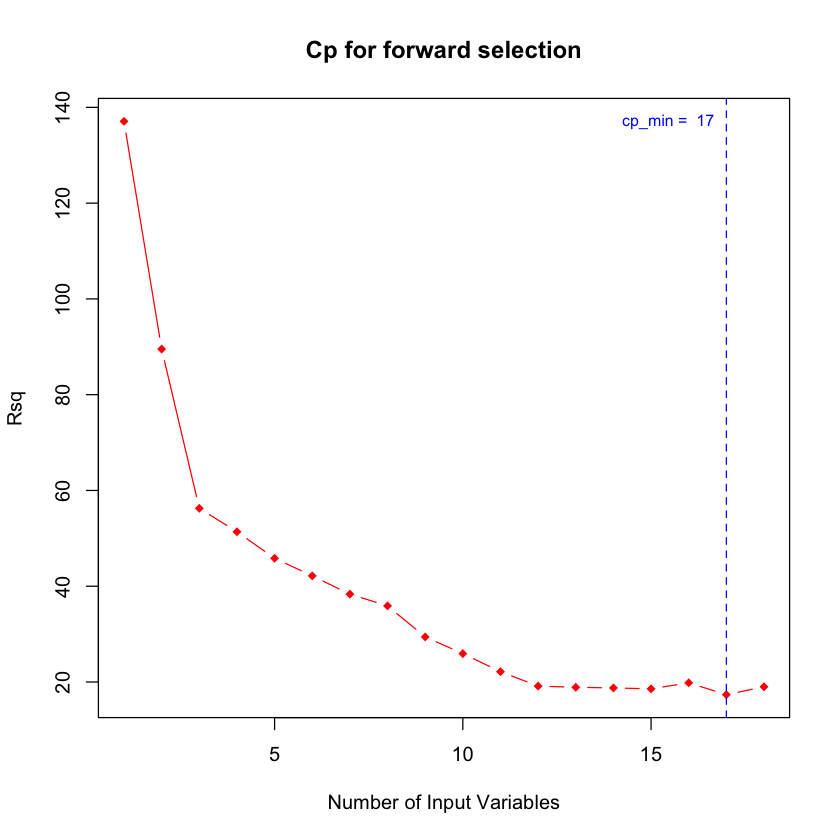

In [20]:
plot(summary(forward_sel)$cp,
     main = "Cp for forward selection",
     xlab = "Number of Input Variables", 
     ylab = "Rsq",
     type = "b",
     pch = 18,
     col = "red"
)
abline(v = cp_min, col = "blue", lty = 2)
text(cp_min, max(summary(forward_sel)$cp), 
     labels = paste("cp_min = ", round(cp_min, 2)), 
     pos = 2,  # Position to the right of the line
     col = "blue", 
     cex = 0.8)

In [21]:
# Configuring the training data matrix
# Remove intercept column (first column in the matrix)
train_no_int <- model_matrix[, -1]
training_subset <- as.data.frame(train_no_int) %>%
    bind_cols(salary_in_usd = train_data$salary_in_usd) %>%
    select(all_of(selected_var), salary_in_usd)
dim(training_subset)
head(training_subset)

[1] 455  18

,experience_levelEX,experience_levelMI,experience_levelSE,employment_typeFL,employment_typeFT,employment_typePT,remote_ratio,company_sizeM,company_sizeS,contasia,contno_am,contoce,contso_am,fieldData Engineering,fieldData Science,fieldMachine Learning,fieldOther,salary_in_usd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1,0,1,0,100,0,0,0,1,0,0,0,0,0,0,140000
2,0,0,1,0,1,0,100,1,0,0,1,0,0,0,1,0,0,140000
3,0,1,0,0,1,0,100,0,0,0,1,0,0,0,0,0,0,135000
4,0,1,0,0,1,0,50,0,0,0,1,0,0,0,1,0,0,130000
5,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,39263
6,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,205300


In [22]:
# Fitting the reduced OLS using variables selected
forward_OLS <- lm(salary_in_usd ~ ., data = training_subset)

In [23]:
# Preparing the testing matrix (without modifying the content)
testing_matrix <- model.matrix(salary_in_usd ~ ., data = test_data)
test_no_int <- testing_matrix[, -1]
testing_subset <- as.data.frame(test_no_int)
missing_vars <- setdiff(selected_var, colnames(testing_subset))
if (length(missing_vars) > 0) {
  # Add missing columns for selected variables to the test set (set to zero for missing dummies)
  testing_subset[missing_vars] <- 0
}
testing_subset <- testing_subset %>%            
    bind_cols(salary_in_usd = test_data$salary_in_usd) %>%
    select(all_of(selected_var), salary_in_usd)
dim(testing_subset)
head(testing_subset)

[1] 152  18

,experience_levelEX,experience_levelMI,experience_levelSE,employment_typeFL,employment_typeFT,employment_typePT,remote_ratio,company_sizeM,company_sizeS,contasia,contno_am,contoce,contso_am,fieldData Engineering,fieldData Science,fieldMachine Learning,fieldOther,salary_in_usd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,260000
2,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,20000
3,0,0,0,0,1,0,100,0,0,0,1,0,0,0,0,0,0,72000
4,0,1,0,0,1,0,50,0,0,0,0,0,0,0,1,0,0,35735
5,0,1,0,0,1,0,100,0,0,0,1,0,0,0,0,0,0,87000
6,0,0,0,0,1,0,100,0,1,1,0,0,0,1,0,0,0,41689


In [24]:
test_data_final <- modelr::add_predictions(testing_subset, forward_OLS, var = "pred_red_OLS")

## OLS selected using Forward Selection, Model Evaluation

In [25]:
# Prevent scientific notation

options(scipen = 999)

# Calculate RMSE
rmse_test <- test_data_final %>%
    metrics(truth = salary_in_usd, estimate = pred_red_OLS) %>%
    filter(.metric == "rmse") %>%
    select(.estimate) %>%
    pull()

# Calculate R-squared
rsq_test <- test_data_final %>%
    metrics(truth = salary_in_usd, estimate = pred_red_OLS) %>%
    filter(.metric == "rsq") %>%
    select(.estimate) %>%
    pull()

n <- nrow(test_data)  
p <- length(selected_var)  

# Calculate Adjusted R-squared
adj_rsq_test <- 1 - ((1 - rsq_test) * (n - 1)) / (n - p - 1)

# Print results
results_table <- tibble(
  Metric = c("RMSE", "R-squared", "Adjusted R-squared"),
  Value = c(rmse_test, rsq_test, adj_rsq_test)
)
results_table

Metric,Value
<chr>,<dbl>
RMSE,48647.0980660
R-squared,0.4130371
Adjusted R-squared,0.3385716


In [ ]:
# Main Developer: Morgan 
full_model <- lm(salary_in_usd ~ ., data = train_data)

test_data_full <- modelr::add_predictions(test_data, full_model, var = "pred_full")

# Calculate RMSE for the full model
rmse_full <- test_data_full %>%
  metrics(truth = salary_in_usd, estimate = pred_full) %>%
  filter(.metric == "rmse") %>%
  select(.estimate) %>%
  pull()

# Calculate R-squared for the full model
rsq_full <- test_data_full %>%
  metrics(truth = salary_in_usd, estimate = pred_full) %>%
  filter(.metric == "rsq") %>%
  select(.estimate) %>%
  pull()

# Calculate Adjusted R-squared for the full model
adj_rsq_full <- 1 - ((1 - rsq_full) * (n - 1)) / (n - ncol(train_data) - 1)

# Print results for the full model
full_model_results <- tibble(
  Metric = c("RMSE", "R-squared", "Adjusted R-squared"),
  Value = c(rmse_full, rsq_full, adj_rsq_full)
)

# Combine results for comparison
comparison_results <- bind_rows(
  results_table %>% mutate(Model = "Reduced Model"),
  full_model_results %>% mutate(Model = "Full Model")
)

comparison_results

Metric,Value,Model
<chr>,<dbl>,<chr>
RMSE,48647.0980660,Reduced Model
R-squared,0.4130371,Reduced Model
Adjusted R-squared,0.3385716,Reduced Model
RMSE,48660.0508354,Full Model
R-squared,0.4118970,Full Model
Adjusted R-squared,0.3833087,Full Model


## Discussion

## References